# Preprocessing

## Structure of the code
1. Combine header and text column
2. Anonymisation
    - Remove names
    - Remove dates
    - Create unique ids for each person
    - Use review and url to remove repeated comments
    - Remove urls
3. Cleaning and processing
    - If a comment was only punctuation => remove that row
4. Balance data (around 17,000 per category)
    - Randomise data (in categories)
    - Keep the first 17,000 of each category

## Initial code

In [158]:
#!pip install -U spacy
#!python -m spacy download da_core_news_md
#!pip install nltk numpy pandas seaborn scikit-learn scipy 

In [159]:
# system tools
import os
import sys
import random
import requests as req

# nlp tools
import spacy
import da_core_news_md
from io import StringIO
import re

# data wranling
import pandas as pd
import numpy as np
from scipy.stats import randint

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

In [160]:
# define path
path = os.path.join("..", "in", "postnord_trustpilot_reviews.csv")

In [161]:
# read csv
df = pd.read_csv(path)
# fill empty columns with white space
df.fillna(" ", inplace = True)
# rename columns
df.columns = ['order', 'name', 'date', 'rating', 'text', 'profile_link', 'review_count', 'header']

In [162]:
# make deep copy of the 20 first lines in the data
#df = df1.copy(deep = True)

In [163]:
print(f"Beginning # of rows {len(df)}")

Beginning # of rows 399980


## Combination of header and text column

Hvis headeren er identisk med teksten eller hvis headerens længde er identisk med det tilsvarende vindue i teksten
    
```df['review'] = df['text']```

Ellers: `df['review'] = df['header'] + " " + df['text']`

_Kan også omvendes_

In [164]:
# remove dots from the end of the header
df['header'] = df['header'].str.replace('…', '', regex = False)

In [165]:
# create a list
review = []

# loop over the dataframe
for index, row in df.iterrows():
    # txt is the text-column
    txt = row["text"]
    # head is the header-column
    head = row["header"]
    # search for the header text in the text-column
    x = re.search(f"^{re.escape(head)}", txt)
    # if the header text occurs in the text-column
    if x:
        # append the text column to the list
        review.append(row['text'])
    # otherwise...
    else:
        # append the header column and the text column to the list with a white space in between
        review.append(row['header'] + " " + row['text'])

In [166]:
# create a new review-column from the list
df['review'] = review

## Removal of duplicates

In [167]:
df = df.drop_duplicates(subset=['profile_link', 'date', 'review'], keep='first')

In [168]:
print(f"# rows after removing duplicates: {len(df)}")

# rows after removing duplicates: 399537


## Anonymisation

In [169]:
df = df.drop(columns=['name', 'date', 'profile_link', 'header', 'text', 'order', 'review_count'])

## Cleaning and processing

In [170]:
clean_review = []

for text in df['review'].tolist():
    text = re.sub('[^\w\s]+', '', text)
    text = re.sub(' +', ' ', text)
    text = text.strip()
    text = text.lower()
    clean_review.append(text)

In [171]:
df['review'] = clean_review

In [172]:
df['review'].replace('', np.nan, inplace=True)
df.dropna(subset=['review'], inplace=True)
print("# rows after removing empty rows:", len(sm))

# rows after removing empty rows: 399980


In [173]:
df.head()

,rating,review
0,5,hurtig levering
1,5,altid pakker til tiden
2,5,som sædvanlig er min pakke leveret på bedste m...
3,5,hurtig behandling alt fungerede hurtig leverin...
4,5,forbilledligt pakkepost når den er bedst


In [174]:
# removal of stopwords
url = "https://gist.githubusercontent.com/berteltorp/0cf8a0c7afea7f25ed754f24cfc2467b/raw/fa34ef448aff6adbb4b6bab9bda62a8b0f1ee597/stopord.txt"
res = req.get(url)

txt_path = os.path.join("..", "in", "stopwords.txt")

file = open(txt_path, "w")
file.write(res.text)
file.close()

In [175]:
with open(txt_path) as f:
    lines = f.readlines()
f.close()

In [176]:
stopwords = []

for l in lines:
    stopwords.append(l.strip())

In [177]:
df['review'] = df['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [178]:
df['review'].replace('', np.nan, inplace=True)
df.dropna(subset=['review'], inplace=True)
print("# rows after removing empty rows (again):", len(df))

# rows after removing empty rows (again): 397199


In [179]:
df.head()

,rating,review
0,5,hurtig levering
1,5,pakker tiden
2,5,sædvanlig pakke leveret bedste måde yderst til...
3,5,hurtig behandling fungerede hurtig leveringtak
4,5,forbilledligt pakkepost bedst


## Lengths

In [180]:
df["length"] = df.review.str.len()

In [181]:
mean_lengths = df.groupby(by = 'rating').mean('length')

In [182]:
mean_lengths

,length
rating,
1,101.331628
2,90.523791
3,74.662603
4,36.467693
5,29.739811


In [183]:
#outpath = os.path.join("..", "out", "length.png")

<Figure size 800x600 with 0 Axes>

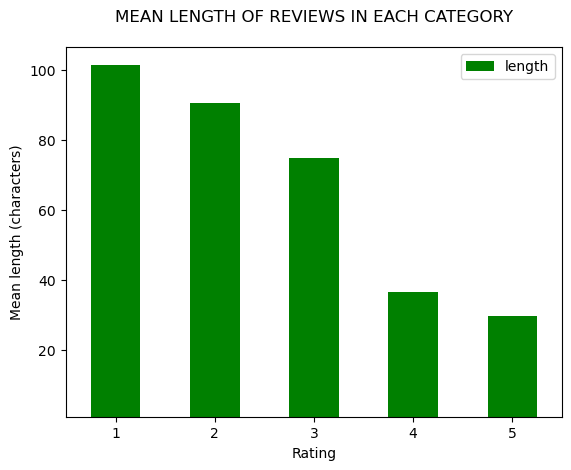

In [184]:
fig = plt.figure(figsize=(8,6))
df.groupby(by = 'rating').mean('length').plot.bar(
    ylim=1, title= 'MEAN LENGTH OF REVIEWS IN EACH CATEGORY\n', color = "green")
plt.xlabel('Rating', fontsize = 10)
plt.ylabel('Mean length (characters)', fontsize = 10)
plt.xticks(rotation='horizontal')
plt.show()
#plt.savefig(outpath, dpi=150)

In [185]:
# show texts that will be removed
print(df.loc[np.array(list(map(len,df.review.values)))<((int(mean_lengths['length'].min()))-14)])

# remove shorter texts
df = df.loc[np.array(list(map(len,df.review.values)))>((int(mean_lengths['length'].min()))-15)]

        rating          review  length
1            5    pakker tiden      12
6            4   gik forventet      13
10           5      sædvanligt      10
17           5         hurtigt       7
22           5      lynhurtigt      10
...        ...             ...     ...
399939       4  kekdkfkfkfkkkd      14
399948       1        langsomt       8
399956       5   hurtig venlig      13
399972       5         udsætte       7
399973       4  fungerede fint      14

[65095 rows x 3 columns]


In [186]:
print("# rows after removing short reviews:", len(df))

# rows after removing short reviews: 332104


In [187]:
df = df.reset_index(drop=True)

In [188]:
df.sort_values("length")

,rating,review,length
0,5,hurtig levering,15
119553,5,hurtig levering,15
119577,5,hurtig levering,15
119580,5,hurtig levering,15
119592,5,track and trace,15
...,...,...,...
25379,1,advarsel dato levering post nord sms d 48 modt...,1383
129394,1,give minus 5 stjerner give minus 5 stjerner va...,1485
222256,1,postnord trænger kundeservice egentligt postno...,1498
79176,1,glemt pakke dovenskab gennemgang mails stykke ...,1658


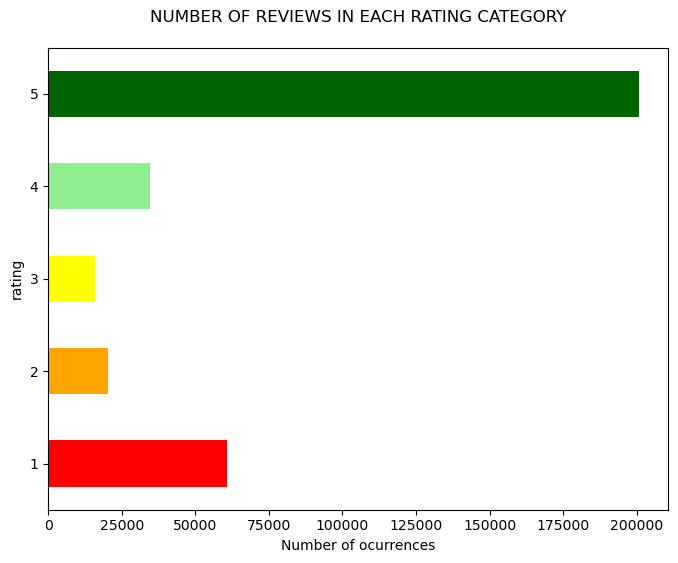

In [189]:
fig = plt.figure(figsize=(8,6))
# PALETTE??
colors = ['red','orange','yellow','lightgreen','darkgreen']
df.groupby('rating').review.count().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF REVIEWS IN EACH RATING CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [190]:
# 17122 3-star reviews
df['rating'].value_counts()

5    200651
1     60823
4     34452
2     20287
3     15891
Name: rating, dtype: int64

In [191]:
def balance(dataframe, random_state = 42):
    """
    Create a balanced sample from imbalanced datasets.
    
    dataframe: 
        Pandas dataframe with a column called 'review' and one called 'rating'
    n:         
        Number of samples from each label, defaults to XXXXX
        
    random_state:
        Random state, defaults to 42
    """
    # Use pandas select a random bunch of examples from each label
    out = (dataframe.groupby('rating', as_index=False)
            .apply(lambda x: x.sample(dataframe['rating'].value_counts().min(), random_state = random_state))
            .reset_index(drop=True))
    
    return out

In [192]:
df = balance(df, random_state = 42)

In [193]:
df['rating'].value_counts()

1    15891
2    15891
3    15891
4    15891
5    15891
Name: rating, dtype: int64

In [194]:
df['rating'] = df['rating'].astype(str)

In [195]:
df = df.reset_index(drop=True)

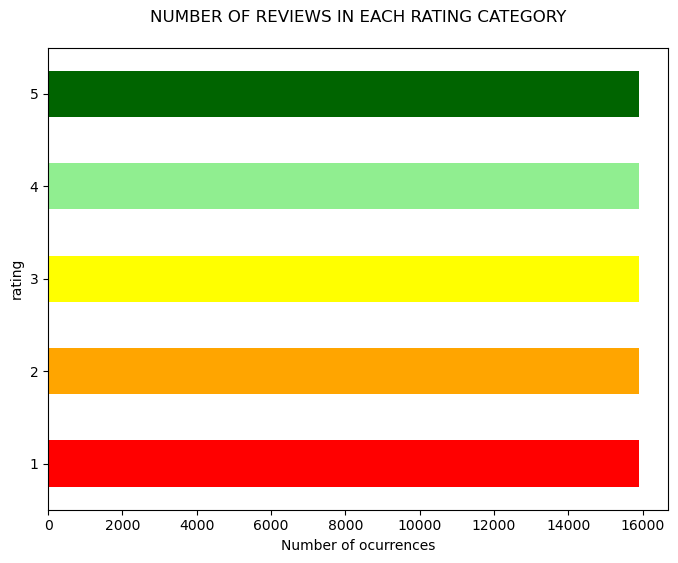

In [196]:
fig = plt.figure(figsize=(8,6))
# PALETTE??
colors = ['red','orange','yellow','lightgreen','darkgreen']
df.groupby('rating').review.count().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF REVIEWS IN EACH RATING CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [197]:
df.sort_values("length")

,rating,review,length
53243,4,hurtig levering,15
6540,1,hurtig levering,15
61267,4,hurtig levering,15
61245,4,hurtig effektiv,15
61243,4,hurtig levering,15
...,...,...,...
6569,1,bestemt fan post nord vælge handler online væl...,984
2198,1,bedes læse svar utilfreds bedes læse svar takj...,1021
15449,1,tilfreds post nord dårlige episoder post nord ...,1037
13174,1,nul mulighed ærgerligt nul mulighed mage inkom...,1075


In [198]:
len(df)

79455

In [199]:
balancepath = os.path.join("..", "in", "balanced_dataset.csv")

In [200]:
df.to_csv(balancepath, index = False)